In [1]:
!pip install ultralytics==8.3.27 -q

# Imports

In [11]:
# Common
import time
import os
import csv
import numpy as np

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Yolo
from ultralytics import YOLO

# Depth Model
from transformers import pipeline

# Constants

In [3]:
BASE_PATH = '/kaggle/input/horse-riding-jumping-walking'

# Util

In [4]:
def get_image_paths(directory, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif", ".mp4")):
    image_paths = []
    
    # Iterate over all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if file is an image based on its extension
            if file.lower().endswith(valid_extensions):
                # Append the full path of the image file to the list
                image_paths.append(os.path.join(root, file))
    
    return image_paths


def plot_image_grid(images, images_per_row=5, total_images=50):
    # Ensure we don't exceed the available images or the limit of 50
    total_images = min(total_images, len(images))
    
    # Calculate the number of rows needed
    num_rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    # Flatten the axes array in case of more than one row
    axs = axs.ravel()

    for i in range(total_images):
        # Read and display the image
        img = images[i]
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off the axis for clean presentation

    # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
    for j in range(total_images, len(axs)):
        axs[j].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()


def extract_frames_from_video(video_path: str) -> list:
    frames = []
    
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Check if the video opened successfully
    if not video_capture.isOpened():
        print("Error: Could not open video.")
        return frames
    
    # Loop through video frames
    while True:
        # Read frame-by-frame
        ret, frame = video_capture.read()
        
        # Break the loop if no frame is captured
        if not ret:
            break
        
        # Append the frame (as a numpy array) to the list
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
    # Release the video capture object
    video_capture.release()
    
    return frames

    
def plt_img(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()

In [5]:
def load_yolo_model():
    # Load the YOLOv5 model
    model = YOLO('yolov5su.pt') # yolov5s.pt, yolov5su.pt
    return model

def detect_horses(model_infer, frame, confidence_threshold=0.8):
    detected_horses = []
    
    # Perform inference on the frame
    results = model_infer(frame)

    # Iterate through detected results
    for result in results:
        for box in result.boxes:
            # Retrieve class name, confidence, and bounding box coordinates
            class_id = int(box.cls)
            class_name = result.names[class_id]  # Get the class name
            confidence = box.conf.item()  # Confidence score

            if (class_name == "horse") and (confidence >= confidence_threshold):
                bbox = box.xyxy[0].tolist()  # Bounding box [x_min, y_min, x_max, y_max]
                detected_horses.append((class_name, confidence, bbox))
                # print(f"Class: {class_name}, Confidence: {confidence:.2f}, BBox: {bbox}")

    return detected_horses

# Model Infers

In [12]:
yolov5_model = load_yolo_model()

In [13]:
depth_pipeline = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

## Step1: Read Video Paths

In [14]:
video_paths = get_image_paths(BASE_PATH)
video_paths

['/kaggle/input/horse-riding-jumping-walking/3.mp4',
 '/kaggle/input/horse-riding-jumping-walking/1.mp4',
 '/kaggle/input/horse-riding-jumping-walking/4.mp4',
 '/kaggle/input/horse-riding-jumping-walking/2.mp4']

In [15]:
video_frames = extract_frames_from_video(video_paths[-1])
len(video_frames)

5029

## Step2: Detecting Horse


0: 384x640 2 persons, 1 horse, 189.7ms
Speed: 1.8ms preprocess, 189.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
239.09117126464844


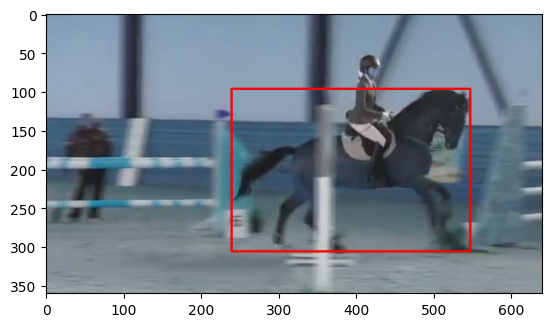

In [16]:
test_frame = video_frames[10]
detected_horses = detect_horses(frame=test_frame, model_infer=yolov5_model)

# Plot first detected horse
if detected_horses:
    horse_details = detected_horses[0]
    x_min, y_min, x_max, y_max = horse_details[2]
    print(x_min)
    test_frame = cv2.rectangle(test_frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255,0,0), 2)
    plt_img(test_frame)
else:
    print("Horse do not exists")